# To-Dos:
- [ ] Change test size at split to 0.2?
- [ ] Add KNN to stacking regressor?

# Project Description

# Establishing professor's baseline

In [4]:
## Import all needed libraries
import numpy as np
import pandas as pd
import json
import logging
import zipfile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error

## Initiate common random state
r_state = 123


In [5]:
# Set up logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Log the start of the process
logging.info("Reading train and test files")

# Read the full dataset
data = pd.read_json("train.json", orient='records')
test = pd.read_json("test.json", orient='records')

# Fill missing 'rooms' where room_type is private/shared/hotel with 1
room_fill_conditions = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room'])

# Only apply the fill where 'rooms' is NaN and room type is a single room type
data.loc[room_fill_conditions & data['rooms'].isna(), 'rooms'] = 1

# Split the full data into train and validation BEFORE any transformation
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)

drop_cols = ['host', 'name', 'facilities', #'guests', 
             'revenue']  # add others like 'beds' or 'cancellation' if needed
label = 'revenue'

X_train = raw_train.drop(columns=drop_cols)
y_train = raw_train[label]  # Do not transform yet

X_valid = raw_valid.drop(columns=drop_cols)
y_valid = raw_valid[label]


2025-05-12 20:12:30,853 - INFO - Reading train and test files


In [6]:
print(X_train.shape)
print(X_valid.shape)

(10178, 12)
(5090, 12)


# Environment set-up & data import

In [8]:
# --- Core ---
import pandas as pd
import numpy as np
import logging

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Preprocessing ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# --- Scikit-learn: Models ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)

# --- Scikit-learn: Metrics ---
from sklearn.metrics import mean_absolute_error

# --- Other ML Libraries ---
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# --- Optional: Feature Engineering Tools ---
# from sklearn.cluster import KMeans
# from geopy.distance import geodesic

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


2025-05-12 20:12:31,109 - DEBUG - matplotlib data path: C:\Users\chels\anaconda3\Lib\site-packages\matplotlib\mpl-data
2025-05-12 20:12:31,113 - DEBUG - CONFIGDIR=C:\Users\chels\.matplotlib
2025-05-12 20:12:31,115 - DEBUG - interactive is False
2025-05-12 20:12:31,115 - DEBUG - platform is win32
2025-05-12 20:12:31,157 - DEBUG - CACHEDIR=C:\Users\chels\.matplotlib
2025-05-12 20:12:31,160 - DEBUG - Using fontManager instance from C:\Users\chels\.matplotlib\fontlist-v330.json
2025-05-12 20:12:31,538 - DEBUG - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-12 20:12:31,541 - DEBUG - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-05-12 20:12:31,543 - DEBUG - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-05-12 20:12:31,544 - DEBUG - deprecate positional args: graphviz.backend.viewing.vie

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load train and test data
logging.info("Loading train and test data...")
data = pd.read_json("train.json", orient="records")
test = pd.read_json("test.json", orient="records")

# Drop unused columns
drop_cols = ['host', 'name']
data.drop(columns=drop_cols, inplace=True)

# Domain-informed imputation: fill missing 'rooms' where room_type implies 1 room
room_fill_mask = data['room_type'].isin(['private_room', 'shared_room', 'hotel_room']) & data['rooms'].isna()
data.loc[room_fill_mask, 'rooms'] = 1 



# Split BEFORE any transformations
r_state = 123
raw_train, raw_valid = train_test_split(data, test_size=1/3, random_state=r_state)




2025-05-12 20:12:32,374 - INFO - Loading train and test data...


# Explore data

From table below, can see that:
- min_nights and num_reviews are heavily skewed (substantial difference between mean and median)
- The top value of min_nights is nonsensical (should be winsorized to avoid losing data)

In [12]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,4.936432,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,25.228179,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,999.000000,1250.000000,5.000000,16.000000,473555.000000


In [13]:
percent_missing = raw_train.isna().sum()*100/len(raw_train)
percent_missing.sort_values(ascending=False)

guests          11.495382
rooms            6.798978
cancellation     1.139713
beds             0.510906
bathrooms        0.019650
lat              0.000000
lon              0.000000
room_type        0.000000
min_nights       0.000000
num_reviews      0.000000
rating           0.000000
listing_type     0.000000
facilities       0.000000
revenue          0.000000
dtype: float64

In [14]:

from scipy.stats import skew

def compare_log_skew(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in numeric_cols:
        original = df[col].dropna()

        # Skip if there are any negative values (but allow zeros for log1p)
        if (original < 0).any():
            continue

        original_skew = skew(original)
        log_skew = skew(np.log1p(original))

        results.append({
            'feature': col,
            'original_skew': round(original_skew, 3),
            'log_skew': round(log_skew, 3),
            'skew_reduction': round(abs(original_skew) - abs(log_skew), 3)
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='skew_reduction', ascending=False)
    return result_df


In [15]:
compare_log_skew(raw_train)

,feature,original_skew,log_skew,skew_reduction
4,min_nights,28.308,2.530,25.777
8,revenue,4.311,-0.552,3.760
2,bathrooms,2.789,-0.104,2.684
3,beds,2.880,0.755,2.125
1,rooms,2.539,1.049,1.490
7,guests,1.862,0.438,1.424
5,num_reviews,1.871,-0.531,1.340
0,lat,0.507,-0.131,0.376
6,rating,-8.466,-10.328,-1.862


## Identify outliers

In [17]:
# Select numeric columns
numeric_cols = raw_train.select_dtypes(include='number')
len(numeric_cols.columns)

10

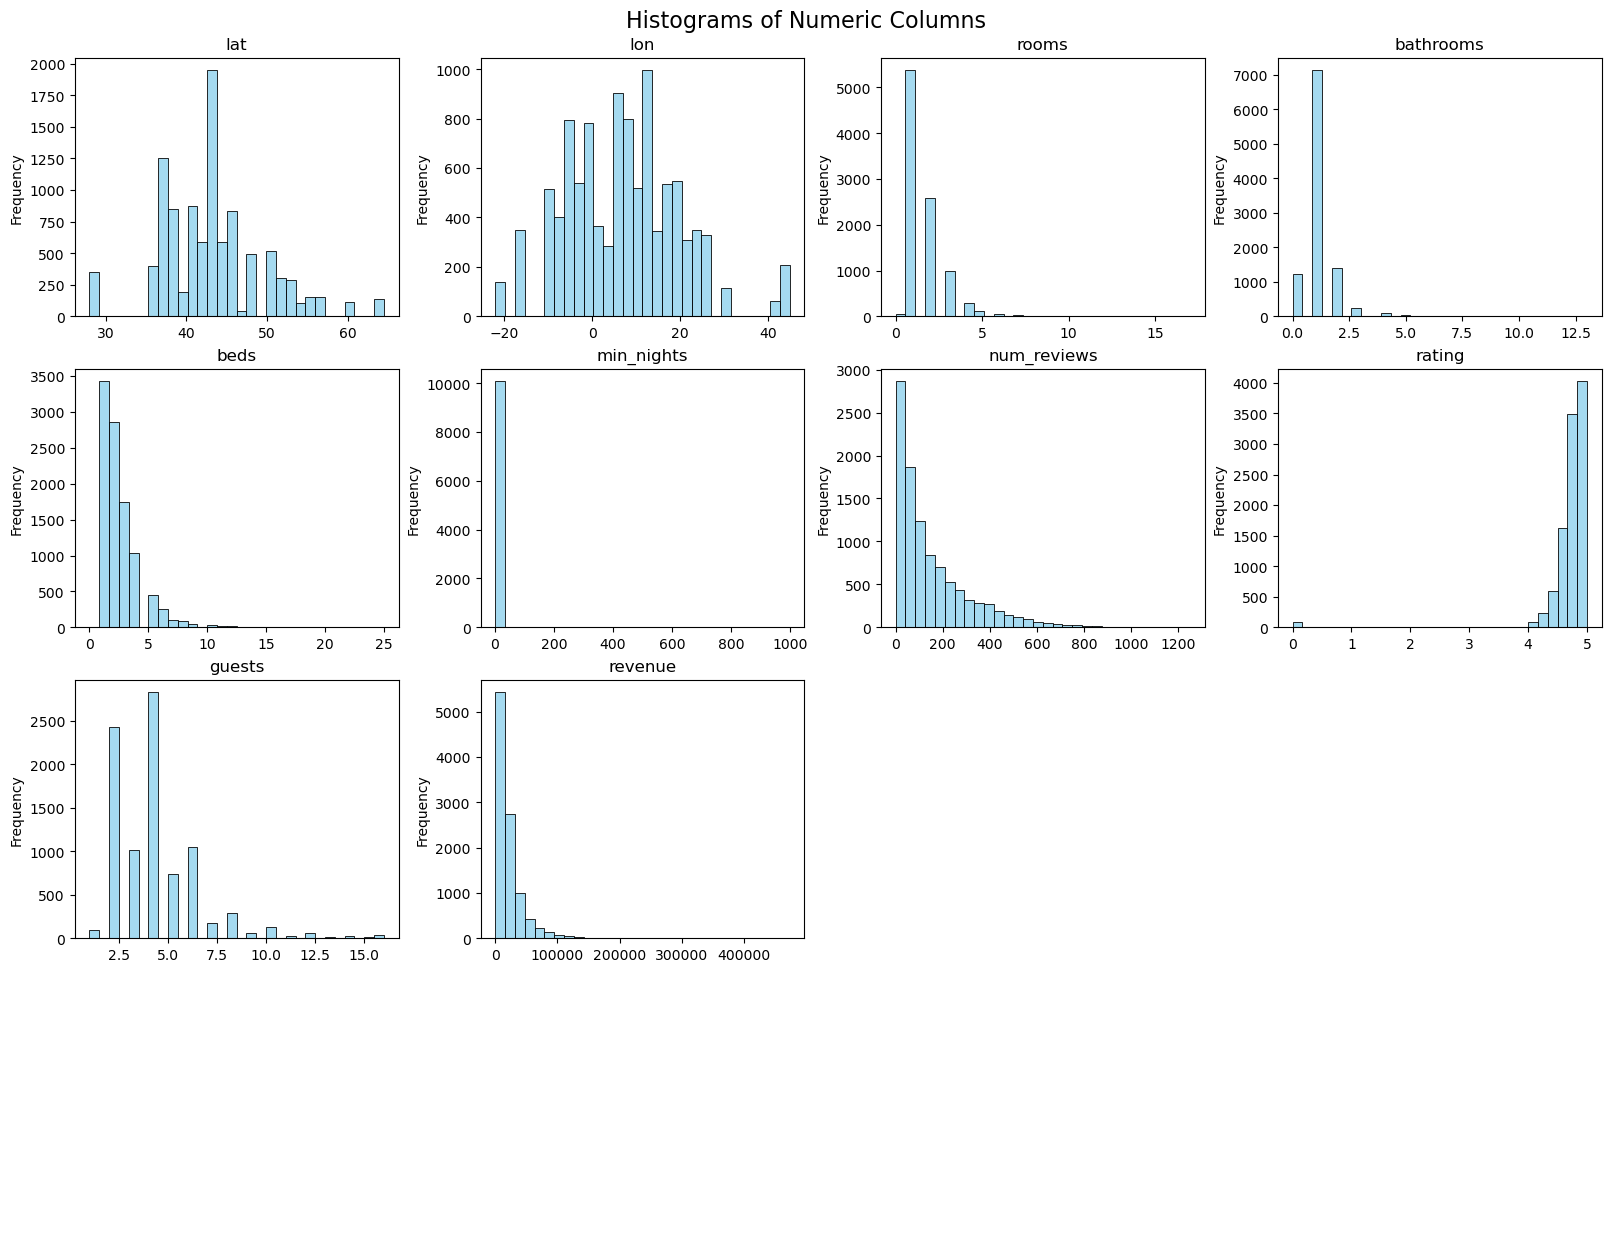

In [18]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12), constrained_layout=True)
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(raw_train[col], ax=axes[i], kde=False, bins=30, color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Histograms of Numeric Columns", fontsize=16, y=1.02)
plt.show()

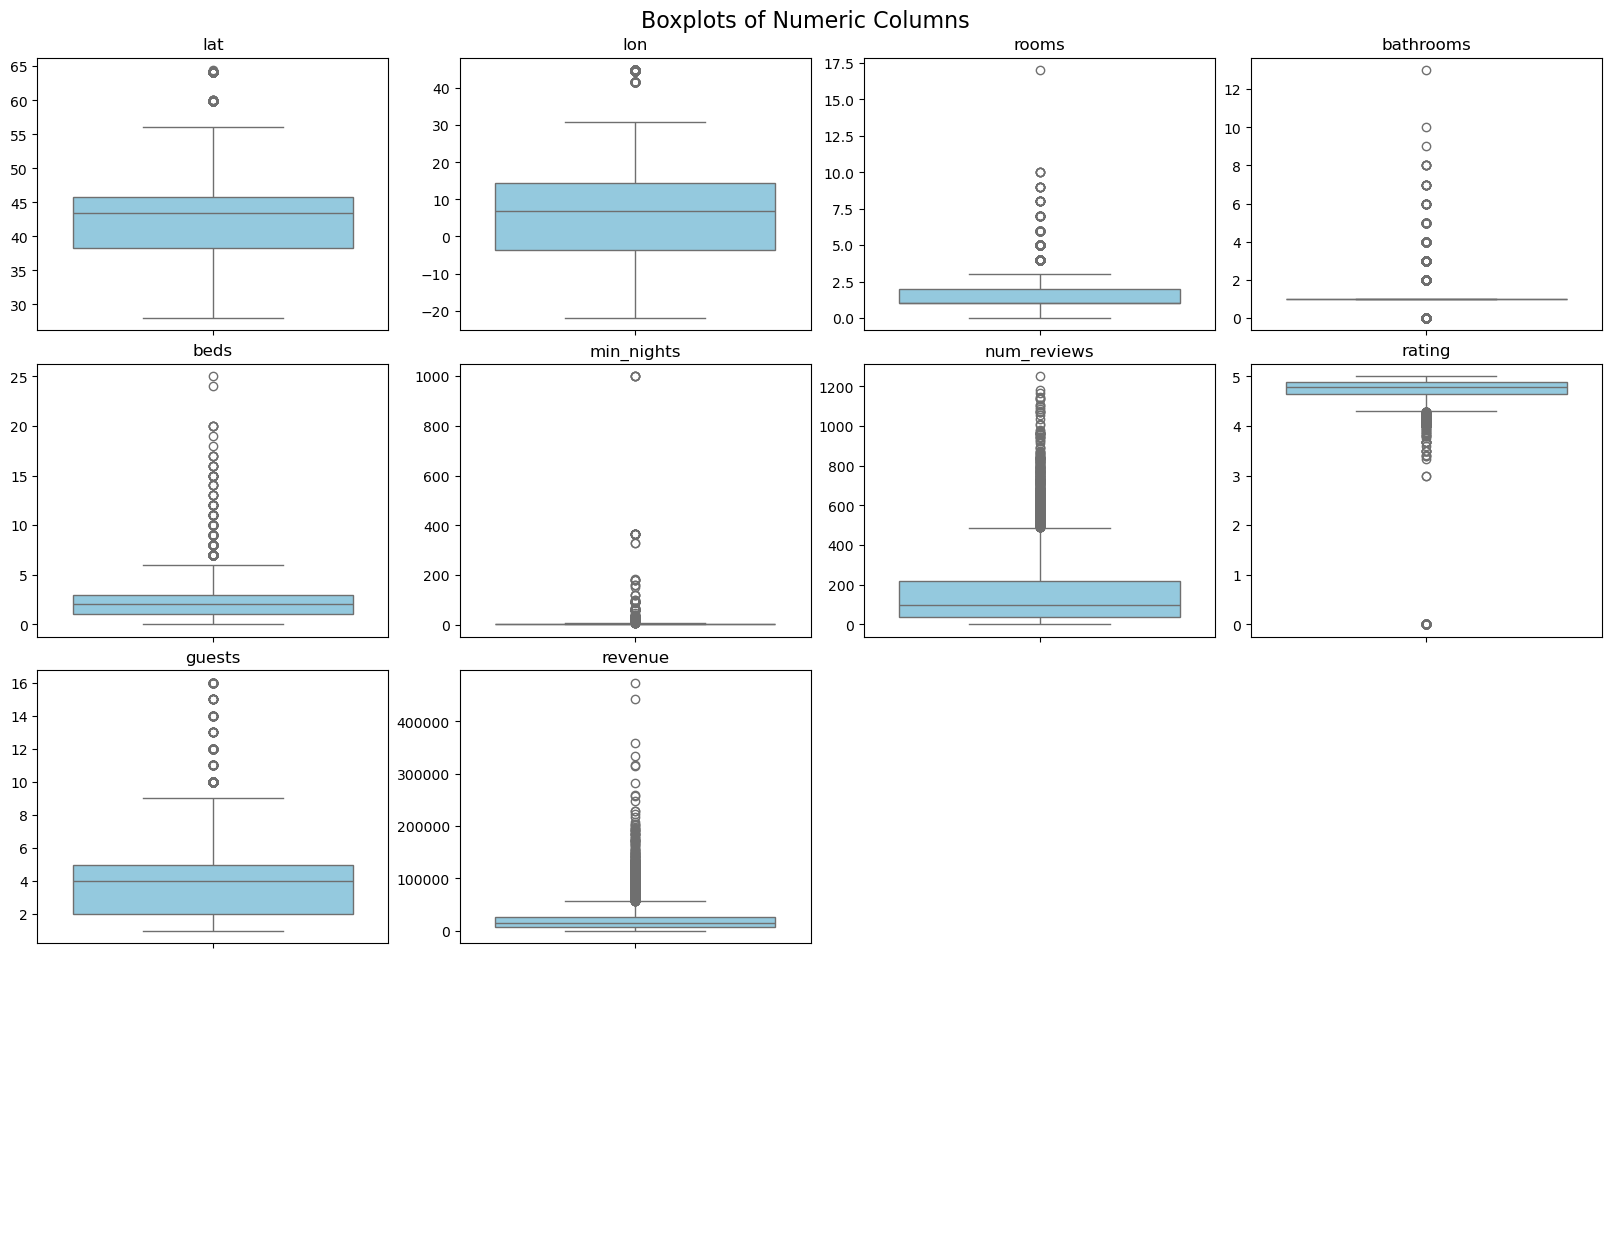

In [19]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12), constrained_layout=True)
axes = axes.flatten()

# Plot each boxplot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=raw_train[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Boxplots of Numeric Columns", fontsize=16, y=1.02)
plt.show()

In [20]:
# Function to count outliers using IQR method
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Apply to all numeric columns
outlier_counts = numeric_cols.apply(count_outliers)

# Print or use the result
print(outlier_counts)

lat             251
lon             266
rooms           500
bathrooms      3036
beds            349
min_nights      484
num_reviews     547
rating          346
guests          310
revenue         696
dtype: int64


In [21]:
cap_value = raw_train['min_nights'].quantile(0.99)
raw_train['min_nights'] = raw_train['min_nights'].clip(upper=cap_value)


In [22]:
raw_train.describe()

,lat,lon,rooms,bathrooms,beds,min_nights,num_reviews,rating,guests,revenue
count,10178.000000,10178.000000,9486.000000,10176.000000,10126.000000,10178.000000,10178.000000,10178.000000,9008.000000,10178.000000
mean,43.277133,6.908554,1.674362,1.128734,2.520837,3.731623,154.674003,4.713978,4.129107,21813.651405
std,6.429093,12.748056,1.040412,0.779804,1.894165,4.980577,166.426781,0.463090,2.232536,25560.354177
min,28.004700,-21.979200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,136.000000
25%,38.356125,-3.592600,1.000000,1.000000,1.000000,2.000000,36.000000,4.650000,2.000000,6904.750000
50%,43.496850,6.987900,1.000000,1.000000,2.000000,2.000000,95.000000,4.790000,4.000000,14648.000000
75%,45.764500,14.423950,2.000000,1.000000,3.000000,4.000000,217.000000,4.890000,5.000000,27112.750000
max,64.421600,44.820800,17.000000,13.000000,25.000000,31.230000,1250.000000,5.000000,16.000000,473555.000000


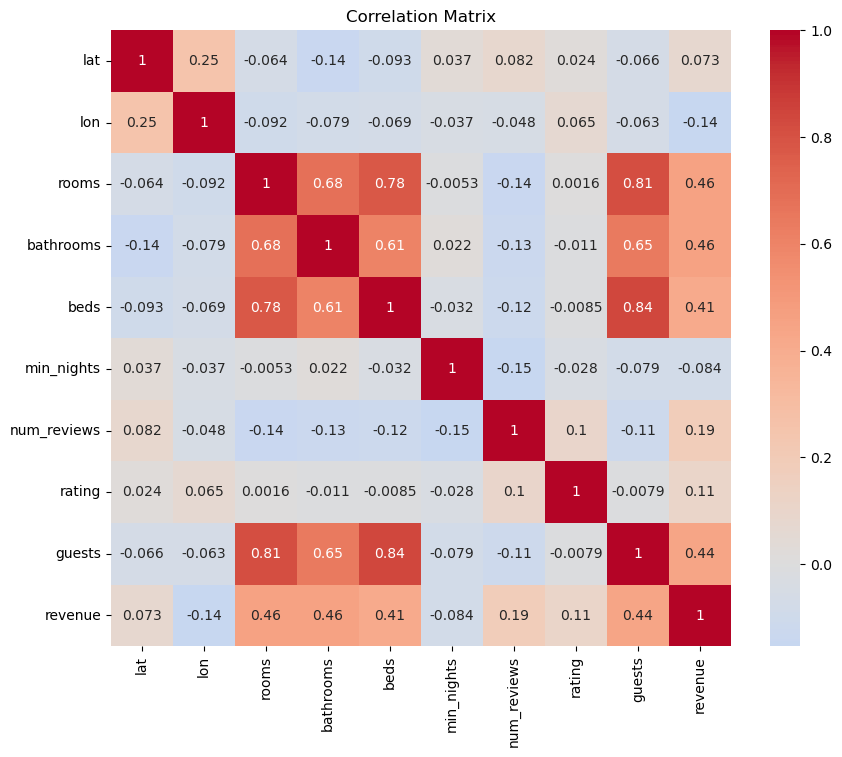

In [23]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


plt.figure(figsize=(10, 8))
sns.heatmap(
    data=raw_train.select_dtypes(include='number').corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Matrix")
plt.show()


# Feature selection & engineering

Baseline model used:
- Only numerical columns (lat, lon, rooms, num_reviews)

Features to keep for the model:
- lat
- lon
- rooms
- room_type
- min_nights
- num_reviews
- rating
- cancellation
- beds
- bathrooms
- guests

Features to drop for the model:
- host
- name
- listing_type
- facilities

Transformations required:
- Log transformation: to deal with skewness of revenue, rooms, min_nights, num_reviews, rating
- Normalization: on all numerical columns so that all are on same scale
- Median imputation, due to skewness: rooms (fill with 1 wherever room_type == shared room, hotel room or private room; fill with the median for all other missing values)
- Mean imputation: lat and lon
- Dummy encoding of categorical variables: room_type

In [26]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3.00,766,4.91,2.0,Entire rental unit,TV Wifi Kitchen Free parking on premises Room-...,Strict,46779
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,31.23,151,4.40,4.0,Entire rental unit,Wifi Kitchen Free parking on premises Hot wate...,Strict,5518
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1.00,194,4.72,4.0,Entire rental unit,TV Cable TV Wifi Crib Kitchen Hot water Elevat...,Moderate,7734
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30.00,20,5.00,4.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Paid...,Strict,23147
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2.00,155,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Hot ...,Moderate,13496


In [27]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,5.0,Entire condo,TV Cable TV Wifi Air conditioning Pool Crib Ki...,Strict,13809
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,6.0,Entire rental unit,TV Washer Cable TV Dryer Smoke alarm Wifi Pool...,Strict,39868
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,2.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Room...,Strict,7180
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,2.0,Entire rental unit,TV Wifi Air conditioning Kitchen Room-darkenin...,Moderate,57623
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Crib Kitchen...,Moderate,32048


## Engineer lat x lon product feature

In [29]:
raw_train['lat_lon_product'] = raw_train['lat'] * raw_train['lon']
raw_valid['lat_lon_product'] = raw_valid['lat'] * raw_valid['lon']
test['lat_lon_product'] = test['lat'] * test['lon']

## Engineer location clusters

In [31]:
from sklearn.cluster import KMeans

def add_location_clusters(df, n_clusters=5):
    coords = df[['lat', 'lon']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['location_cluster'] = kmeans.fit_predict(coords)
    return df


In [32]:
raw_train = add_location_clusters(raw_train, n_clusters=5)
raw_valid = add_location_clusters(raw_valid, n_clusters=5)
test = add_location_clusters(test, n_clusters=5)

## Engineer rating credibility feature

In [34]:
# Feature engineering on raw_train and raw_valid
raw_train['rating_weighted'] = raw_train['rating'] * np.log1p(raw_train['num_reviews'])
raw_valid['rating_weighted'] = raw_valid['rating'] * np.log1p(raw_valid['num_reviews'])
test['rating_weighted'] = test['rating'] * np.log1p(test['num_reviews'])

## Engineer facilities count

In [36]:
import re

def count_facilities(text):
    if pd.isnull(text):
        return 0
    # Count based on capitalized facility phrases
    return len(re.findall(r'[A-Z][^A-Z]*', str(text).strip()))

In [37]:
raw_train['facility_count'] = raw_train['facilities'].apply(count_facilities)
raw_valid['facility_count'] = raw_valid['facilities'].apply(count_facilities)
test['facility_count'] = test['facilities'].apply(count_facilities)

In [38]:
raw_train['facility_count'].value_counts()

facility_count
29    294
27    294
31    292
33    292
30    288
     ... 
1       2
2       1
85      1
95      1
86      1
Name: count, Length: 88, dtype: int64

## Most profitable facilities

In [40]:
# Split the facilities string into a list of words
raw_train['facility_list'] = raw_train['facilities'].str.split(' ')

# Explode so each word becomes its own row
df_exploded = raw_train.explode('facility_list')

# Group by facility word and calculate average revenue
facility_revenue = df_exploded.groupby('facility_list')['revenue'].mean().sort_values(ascending=False)

# Optional: also count how often each word appears
facility_counts = df_exploded['facility_list'].value_counts()

# Combine into one DataFrame
summary = pd.DataFrame({
    'mean_revenue': facility_revenue,
    'count': facility_counts
}).sort_values(by='mean_revenue', ascending=False)

print(summary.head(20))  # Show top 20 facilities by revenue


                 mean_revenue  count
facility_list                       
Sauna            45845.500000     48
pong             41430.593985    133
Ping             41430.593985    133
bikes            38641.290323     31
slip             36588.857143     21
Boat             36588.857143     21
monitor          35760.633333     60
Piano            35647.755814    172
Fireplace        35361.888000    125
loungers         35189.187008    508
Sun              35189.187008    508
shower           34567.285714    308
Life             33404.812500     16
size             33404.812500     16
recommendations  33380.952218    586
Babysitter       33380.952218    586
playroom         33246.325581     43
Children's       33246.325581     43
kitchen          32923.833333    114
system           32731.585333    750


In [41]:
# Define the keywords to search for
key_facilities = ['Sauna', 'pong', 'Ping', 'bikes']

# Create the binary column
raw_train['profitable_facilities'] = raw_train['facilities'].apply(
    lambda x: 'yes' if pd.notnull(x) and any(kw in x for kw in key_facilities) else 'no'
)
raw_valid['profitable_facilities'] = raw_valid['facilities'].apply(
    lambda x: 'yes' if pd.notnull(x) and any(kw in x for kw in key_facilities) else 'no'
)

# Optional: check result
print(raw_train[['facilities', 'profitable_facilities']].head())
print(raw_valid[['facilities', 'profitable_facilities']].head())


                                              facilities profitable_facilities
2148   TV Wifi Kitchen Free parking on premises Room-...                    no
7024   Wifi Kitchen Free parking on premises Hot wate...                    no
14508  TV Cable TV Wifi Crib Kitchen Hot water Elevat...                    no
5286   TV Cable TV Wifi Air conditioning Kitchen Paid...                    no
10231  TV Cable TV Wifi Air conditioning Kitchen Hot ...                    no
                                             facilities profitable_facilities
738   TV Cable TV Wifi Air conditioning Pool Crib Ki...                    no
4759  TV Washer Cable TV Dryer Smoke alarm Wifi Pool...                    no
4197  TV Cable TV Wifi Air conditioning Kitchen Room...                    no
7320  TV Wifi Air conditioning Kitchen Room-darkenin...                    no
8967  TV Cable TV Wifi Air conditioning Crib Kitchen...                    no


## Finalize data for models

In [43]:
raw_train.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue,lat_lon_product,location_cluster,rating_weighted,facility_count,facility_list,profitable_facilities
2148,55.9672,-3.1838,1.0,1.0,entire_home,1.0,3.00,766,4.91,2.0,Entire rental unit,TV Wifi Kitchen Free parking on premises Room-...,Strict,46779,-178.188371,3,32.614610,38,"[TV, Wifi, Kitchen, Free, parking, on, premise...",no
7024,52.4999,13.4090,2.0,1.0,entire_home,4.0,31.23,151,4.40,4.0,Entire rental unit,Wifi Kitchen Free parking on premises Hot wate...,Strict,5518,703.971159,0,22.105074,21,"[Wifi, Kitchen, Free, parking, on, premises, H...",no
14508,48.2041,16.3656,1.0,1.0,entire_home,1.0,1.00,194,4.72,4.0,Entire rental unit,TV Cable TV Wifi Crib Kitchen Hot water Elevat...,Moderate,7734,788.889019,2,24.888558,26,"[TV, Cable, TV, Wifi, Crib, Kitchen, Hot, wate...",no
5286,47.4982,19.0567,2.0,1.0,entire_home,2.0,30.00,20,5.00,4.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Paid...,Strict,23147,905.158948,2,15.222612,31,"[TV, Cable, TV, Wifi, Air, conditioning, Kitch...",no
10231,50.0687,19.9278,2.0,1.0,entire_home,3.0,2.00,155,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Hot ...,Moderate,13496,997.759040,2,23.784822,28,"[TV, Cable, TV, Wifi, Air, conditioning, Kitch...",no


In [44]:
raw_valid.head()

,lat,lon,rooms,bathrooms,room_type,beds,min_nights,num_reviews,rating,guests,listing_type,facilities,cancellation,revenue,lat_lon_product,location_cluster,rating_weighted,facility_count,profitable_facilities
738,37.0903,-8.2479,2.0,1.0,entire_home,5.0,7,18,4.83,5.0,Entire condo,TV Cable TV Wifi Air conditioning Pool Crib Ki...,Strict,13809,-305.917085,0,14.221640,45,no
4759,43.6912,7.2273,3.0,2.0,entire_home,5.0,5,19,4.74,6.0,Entire rental unit,TV Washer Cable TV Dryer Smoke alarm Wifi Pool...,Strict,39868,315.769410,1,14.199771,24,no
4197,40.1852,44.5066,NaN,1.0,entire_home,1.0,4,89,4.94,2.0,Entire rental unit,TV Cable TV Wifi Air conditioning Kitchen Room...,Strict,7180,1788.506622,3,22.229060,39,no
7320,43.7735,11.2566,1.0,1.0,entire_home,2.0,2,456,4.79,2.0,Entire rental unit,TV Wifi Air conditioning Kitchen Room-darkenin...,Moderate,57623,492.740780,1,29.337233,39,no
8967,41.1494,-8.6066,3.0,1.0,entire_home,5.0,1,209,4.71,6.0,Entire rental unit,TV Cable TV Wifi Air conditioning Crib Kitchen...,Moderate,32048,-354.156426,0,25.184876,39,no


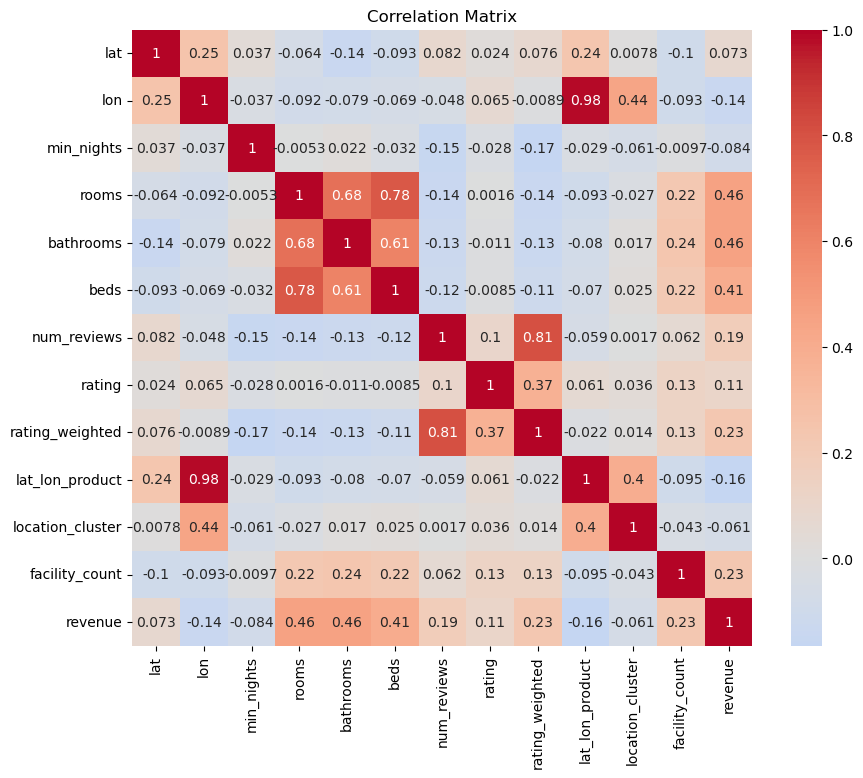

In [79]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


plt.figure(figsize=(10, 8))
sns.heatmap(
    data=raw_train[['lat', 'lon','min_nights','rooms','bathrooms','beds', 
                    'num_reviews','rating', 'rating_weighted', 'lat_lon_product','location_cluster', 'facility_count', 'revenue']].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Matrix")
plt.show()


In [46]:
for i in [raw_train, raw_valid]:
    i.drop(labels=['facilities'], axis=1,inplace=True)

In [47]:
# Define target variable
target_col = 'revenue'

# Split raw_train into X and y
X_train = raw_train.drop(columns=[target_col])
y_train = raw_train[target_col]

# Split raw_valid into X and y
X_valid = raw_valid.drop(columns=[target_col])
y_valid = raw_valid[target_col]

# For log-transformed regression:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)  # (optional, if needed for eval)

# Function Design

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
import pandas as pd

def make_preprocessor(imputation='simple', feature_set='basic'):
    # === Step 1: Define which features to use based on the feature_set ===
    if feature_set == 'basic':
        numeric_features = ['lat', 'lon']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation', 'listing_type', 'profitable_facilities'
                               ]
    elif feature_set == 'engineered':
        numeric_features = ['lat', 'lon', 'rating_weighted',
                            'lat_lon_product', 'location_cluster']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests', 'num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation', 'listing_type', 'profitable_facilities'
                               ]
    elif feature_set == 'engineered_reduced':
        numeric_features = ['rating_weighted', 'lat_lon_product', 'location_cluster']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation', 'listing_type', 'profitable_facilities'
                               ]
    elif feature_set == 'mixed':
        numeric_features = ['lat', 'lon', 'rating_weighted', 'facility_count']
        skewed_num = ['min_nights', 'rooms', 'bathrooms',
                            'beds', 'guests','num_reviews', 'rating']
        categorical_features = ['room_type', 'cancellation', 'listing_type', 'profitable_facilities'
                               ]
    else:
        raise ValueError("Invalid feature_set")

    # Store the list of all selected feature columns
    selected_features = numeric_features + skewed_num + categorical_features

    # === Step 2: Define the column selector ===
    # This function will slice the full DataFrame to only include selected columns
    def select_columns(X):
        return X[selected_features]

    # Wrap the column selector in a transformer so it can be used inside a pipeline
    selector = FunctionTransformer(select_columns)

    # Always define these so they exist when building the pipelines
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')
    
    # Select imputer for the standard numeric pipeline
    if imputation == 'simple':
        num_imputer = mean_imputer
    elif imputation == 'knn':
        num_imputer = KNNImputer(n_neighbors=5)
    elif imputation == 'iterative':
        num_imputer = IterativeImputer(random_state=r_state)
    else:
        raise ValueError("Invalid imputation type")


    # # === Step 3: Choose numeric imputation strategy ===
    # if imputation == 'simple':
    #     mean_imputer = SimpleImputer(strategy='mean')
    #     median_imputer = SimpleImputer(strategy='median')
    # elif imputation == 'knn':
    #     num_imputer = KNNImputer(n_neighbors=5)
    # elif imputation == 'iterative':
    #     num_imputer = IterativeImputer(random_state=0)
    # else:
    #     raise ValueError("Invalid imputation type")

    # === Step 4: Build the pipelines for numeric and categorical preprocessing ===

    # Numeric pipeline: impute + scale
    numeric_pipeline = Pipeline(steps=[
        ('imputer', mean_imputer),
        ('scaler', StandardScaler())
    ])

    # Skewed Numeric pipeline: impute + log transform + scale
    skewed_num_pipeline = Pipeline(steps=[
        ('imputer', median_imputer),
        ('log', FunctionTransformer(np.log1p, validate=True)),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline: impute + one-hot encode
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # === Step 5: Combine pipelines using ColumnTransformer ===
    column_transform = ColumnTransformer(transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('skew', skewed_num_pipeline, skewed_num),
        ('cat', categorical_pipeline, categorical_features)
    ])

    # === Step 6: Wrap the column selector and transformer in a full pipeline ===
    # This ensures only the selected columns go into the preprocessor
    full_preprocessor = Pipeline(steps=[
        ('select', selector),
        ('transform', column_transform)
    ])

    # Optional: give it a name for logging
    preprocessor_name = f"{imputation}_{feature_set}"

    return full_preprocessor, preprocessor_name


In [50]:
def pipeline_iterator(model_type, imputation, feature_set, search_type=None, param_grid=None, n_iter=100, cv_folds=5):
    if search_type not in [None, 'grid', 'random']:
        raise ValueError("search_type must be None, 'grid', or 'random'.")

    if search_type in ['grid', 'random'] and param_grid is None:
        raise ValueError("param_grid must be provided for search_type='grid' or 'random'.")

    if search_type is None and param_grid is not None:
        logging.warning("param_grid is ignored since search_type is None.")

    # Instantiate model with random_state if possible
    try:
        model_instance = model_type(random_state=r_state)
    except TypeError:
        model_instance = model_type()

    # Define the pipeline
    preprocessor, preprocessor_name = make_preprocessor(imputation=imputation, feature_set=feature_set)
    logging.info(f"Using preprocessor: {preprocessor_name}")
    model_pipeline = make_pipeline(preprocessor, model_instance)


    # Select the estimator based on search_type
    if search_type == 'random':
        estimator = RandomizedSearchCV(
            estimator=model_pipeline,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            random_state=r_state,
            n_jobs=-1,
            verbose=1
        )
    elif search_type == 'grid':
        estimator = GridSearchCV(
            estimator=model_pipeline,
            param_grid=param_grid,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            verbose=1
        )
    else:
        estimator = model_pipeline

    logging.info(f"Fitting model: {model_type.__name__} using {preprocessor_name} and search_type: {search_type or 'none'}")
    estimator.fit(X_train, y_train_log)

    # If using CV, get the best estimator
    if search_type in ['grid', 'random']:
        best_model = estimator.best_estimator_
        logging.info(f"Best params: {estimator.best_params_}")
    else:
        best_model = estimator

    # Predictions
    train_preds_log = best_model.predict(X_train)
    valid_preds_log = best_model.predict(X_valid)

    train_preds = np.expm1(train_preds_log)
    valid_preds = np.expm1(valid_preds_log)

    train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
    valid_mae = mean_absolute_error(y_valid, valid_preds)

    logging.info(f"{model_type.__name__} train MAE: {train_mae:.2f}")
    logging.info(f"{model_type.__name__} valid MAE: {valid_mae:.2f}")

    # return best_model

    return {
    'pipeline': estimator,  
    'train_mae': train_mae,
    'valid_mae': valid_mae,
    'mae_diff': abs(train_mae - valid_mae),
    'feature_set': feature_set  
        }



# Function Runs - Linear Models

In [52]:
imputation_types = ['simple','knn','iterative']
feature_sets = ['basic','engineered','engineered_reduced', 'mixed']

## Simple Linear Regression

In [54]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=LinearRegression,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:12:35,881 - INFO - Using preprocessor: simple_basic
2025-05-12 20:12:35,882 - INFO - Fitting model: LinearRegression using simple_basic and search_type: none
2025-05-12 20:12:35,974 - INFO - LinearRegression train MAE: 10960.02
2025-05-12 20:12:35,975 - INFO - LinearRegression valid MAE: 10862.36
2025-05-12 20:12:35,975 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:12:35,976 - INFO - Fitting model: LinearRegression using simple_engineered and search_type: none
2025-05-12 20:12:36,243 - INFO - LinearRegression train MAE: 10678.51
2025-05-12 20:12:36,243 - INFO - LinearRegression valid MAE: 10518.95
2025-05-12 20:12:36,243 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:12:36,244 - INFO - Fitting model: LinearRegression using simple_engineered_reduced and search_type: none
2025-05-12 20:12:36,327 - INFO - LinearRegression train MAE: 10866.19
2025-05-12 20:12:36,327 - INFO - LinearRegression valid MAE: 10911.72
2025-05-12 20:12:36,327 - IN

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10678.508769
valid_mae                                           10518.953283
mae_diff                                              159.555485
feature_set                                           engineered
imputation                                                simple
features                                              engineered
Name: 1, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10866.188779
valid_mae                                           10911.720589
mae_diff                                                45.53181
feature_set                                   engineered_reduced
imputation                                                simple
features                                      engineered_reduced

## Lasso 

In [56]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Lasso,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:12:37,171 - INFO - Using preprocessor: simple_basic
2025-05-12 20:12:37,172 - INFO - Fitting model: Lasso using simple_basic and search_type: none
2025-05-12 20:12:37,248 - INFO - Lasso train MAE: 14798.56
2025-05-12 20:12:37,248 - INFO - Lasso valid MAE: 14397.86
2025-05-12 20:12:37,248 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:12:37,250 - INFO - Fitting model: Lasso using simple_engineered and search_type: none
2025-05-12 20:12:37,310 - INFO - Lasso train MAE: 14798.56
2025-05-12 20:12:37,310 - INFO - Lasso valid MAE: 14397.86
2025-05-12 20:12:37,310 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:12:37,311 - INFO - Fitting model: Lasso using simple_engineered_reduced and search_type: none
2025-05-12 20:12:37,388 - INFO - Lasso train MAE: 14798.56
2025-05-12 20:12:37,388 - INFO - Lasso valid MAE: 14397.86
2025-05-12 20:12:37,389 - INFO - Using preprocessor: simple_mixed
2025-05-12 20:12:37,389 - INFO - Fitting model: Lasso using s

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           14798.556994
valid_mae                                           14397.861409
mae_diff                                              400.695585
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           14798.556994
valid_mae                                           14397.861409
mae_diff                                              400.695585
feature_set                                                basic
imputation                                                simple
features                                                   basic

## Ridge

In [58]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=Ridge,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:12:37,988 - INFO - Using preprocessor: simple_basic
2025-05-12 20:12:37,989 - INFO - Fitting model: Ridge using simple_basic and search_type: none
2025-05-12 20:12:38,070 - INFO - Ridge train MAE: 10968.19
2025-05-12 20:12:38,071 - INFO - Ridge valid MAE: 10846.41
2025-05-12 20:12:38,072 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:12:38,072 - INFO - Fitting model: Ridge using simple_engineered and search_type: none
2025-05-12 20:12:38,140 - INFO - Ridge train MAE: 10687.79
2025-05-12 20:12:38,141 - INFO - Ridge valid MAE: 10504.21
2025-05-12 20:12:38,141 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:12:38,142 - INFO - Fitting model: Ridge using simple_engineered_reduced and search_type: none
2025-05-12 20:12:38,213 - INFO - Ridge train MAE: 10875.61
2025-05-12 20:12:38,213 - INFO - Ridge valid MAE: 10899.26
2025-05-12 20:12:38,213 - INFO - Using preprocessor: simple_mixed
2025-05-12 20:12:38,214 - INFO - Fitting model: Ridge using s

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10687.787142
valid_mae                                           10504.213177
mae_diff                                              183.573965
feature_set                                           engineered
imputation                                                simple
features                                              engineered
Name: 1, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                           10875.612115
valid_mae                                           10899.262043
mae_diff                                               23.649927
feature_set                                   engineered_reduced
imputation                                                simple
features                                      engineered_reduced

# KNN

In [60]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=KNeighborsRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:12:38,887 - INFO - Using preprocessor: simple_basic
2025-05-12 20:12:38,888 - INFO - Fitting model: KNeighborsRegressor using simple_basic and search_type: none
2025-05-12 20:12:43,793 - INFO - KNeighborsRegressor train MAE: 9157.15
2025-05-12 20:12:43,794 - INFO - KNeighborsRegressor valid MAE: 10891.03
2025-05-12 20:12:43,794 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:12:43,794 - INFO - Fitting model: KNeighborsRegressor using simple_engineered and search_type: none
2025-05-12 20:12:49,194 - INFO - KNeighborsRegressor train MAE: 8963.62
2025-05-12 20:12:49,195 - INFO - KNeighborsRegressor valid MAE: 10910.10
2025-05-12 20:12:49,196 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:12:49,196 - INFO - Fitting model: KNeighborsRegressor using simple_engineered_reduced and search_type: none
2025-05-12 20:12:54,063 - INFO - KNeighborsRegressor train MAE: 9210.82
2025-05-12 20:12:54,064 - INFO - KNeighborsRegressor valid MAE: 11328.21
2025

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            9180.959823
valid_mae                                           10870.257209
mae_diff                                             1689.297386
feature_set                                                mixed
imputation                                                simple
features                                                   mixed
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            9180.959823
valid_mae                                           10870.257209
mae_diff                                             1689.297386
feature_set                                                mixed
imputation                                                simple
features                                                   mixed

In [61]:
param_grid_knn = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11, 15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski'],
    'kneighborsregressor__p': [1, 2],  # Only relevant if metric is 'minkowski'; p=1 is manhattan, p=2 is euclidean
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


best_rf = pipeline_iterator(
            model_type=KNeighborsRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_knn,
            n_iter=50,
            cv_folds=5
        )

2025-05-12 20:13:38,413 - INFO - Using preprocessor: simple_mixed
2025-05-12 20:13:38,414 - INFO - Fitting model: KNeighborsRegressor using simple_mixed and search_type: random


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-05-12 20:14:13,072 - INFO - Best params: {'kneighborsregressor__weights': 'distance', 'kneighborsregressor__p': 1, 'kneighborsregressor__n_neighbors': 11, 'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__algorithm': 'brute'}
2025-05-12 20:14:13,650 - INFO - KNeighborsRegressor train MAE: 0.00
2025-05-12 20:14:13,652 - INFO - KNeighborsRegressor valid MAE: 10208.44


# Function Runs - Tree Models

## Random Forest

In [81]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=RandomForestRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:17:43,734 - INFO - Using preprocessor: simple_basic
2025-05-12 20:17:43,735 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: none
2025-05-12 20:18:09,430 - INFO - RandomForestRegressor train MAE: 4070.16
2025-05-12 20:18:09,430 - INFO - RandomForestRegressor valid MAE: 9346.64
2025-05-12 20:18:09,435 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:18:09,436 - INFO - Fitting model: RandomForestRegressor using simple_engineered and search_type: none
2025-05-12 20:18:41,228 - INFO - RandomForestRegressor train MAE: 4046.19
2025-05-12 20:18:41,228 - INFO - RandomForestRegressor valid MAE: 9428.04
2025-05-12 20:18:41,229 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:18:41,229 - INFO - Fitting model: RandomForestRegressor using simple_engineered_reduced and search_type: none
2025-05-12 20:19:07,764 - INFO - RandomForestRegressor train MAE: 4254.67
2025-05-12 20:19:07,765 - INFO - RandomForestRegressor valid MA

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            4070.162221
valid_mae                                            9346.640976
mae_diff                                             5276.478755
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            4070.162221
valid_mae                                            9346.640976
mae_diff                                             5276.478755
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [83]:
param_grid_rf = {
    'randomforestregressor__max_depth': [10, 20, 30, None],  # control overfitting
    'randomforestregressor__n_estimators': [100, 200, 300],  # beyond 300 shows diminishing returns
    'randomforestregressor__min_samples_split': [2, 5, 10],  # control node splitting sensitivity
    'randomforestregressor__min_samples_leaf': [1, 2, 4],    # avoid deep trees with tiny leaves
    'randomforestregressor__max_features': ['sqrt', 'log2']  # 'auto' == 'sqrt' for regression
}

best_rf = pipeline_iterator(
            model_type=RandomForestRegressor,
            imputation='simple',
            feature_set='basic',
            search_type='random',
            param_grid=param_grid_rf,
            n_iter=100,
            cv_folds=5
        )

2025-05-12 20:24:47,721 - INFO - Using preprocessor: simple_basic
2025-05-12 20:24:47,721 - INFO - Fitting model: RandomForestRegressor using simple_basic and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-12 20:27:45,580 - INFO - Best params: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': None}
2025-05-12 20:27:46,053 - INFO - RandomForestRegressor train MAE: 4282.04
2025-05-12 20:27:46,053 - INFO - RandomForestRegressor valid MAE: 9768.16


### Feature Importance

In [85]:
def get_selected_features(feature_set):
    if feature_set == 'basic':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests',
                'num_reviews', 'rating', 'room_type', 'cancellation', 'listing_type', 'profitable_facilities'
               ]
    elif feature_set == 'engineered':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests', 'num_reviews',
                'rating', 'rating_weighted', 'lat_lon_product', 'location_cluster', 
                'room_type', 'cancellation', 'listing_type', 'profitable_facilities'
               ]
    elif feature_set == 'engineered_reduced':
        return ['min_nights', 'rooms', 'bathrooms', 'beds', 'guests','rating_weighted',
                'lat_lon_product', 'location_cluster', 'room_type', 'cancellation', 'listing_type', 'profitable_facilities'
               ]
    elif feature_set == 'mixed':
        return ['lat', 'lon', 'min_nights', 'rooms', 'bathrooms', 'beds', 'guests',
                'num_reviews', 'rating', 'rating_weighted', 'facility_count',
                'room_type', 'cancellation', 'listing_type', 'profitable_facilities'
               ]
    else:
        raise ValueError("Invalid feature_set")


In [86]:
feature_set_used = best_rf['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [87]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_rf['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


                  feature  importance_mean  importance_std
7             num_reviews         0.159698        0.004217
1                     lon         0.120467        0.003004
8                  rating         0.040236        0.003403
0                     lat         0.039072        0.001893
3                   rooms         0.032803        0.001873
9               room_type         0.029585        0.001762
4               bathrooms         0.020774        0.001907
6                  guests         0.017723        0.001979
10           cancellation         0.013491        0.001710
5                    beds         0.013073        0.001084
2              min_nights         0.012543        0.000709
11           listing_type         0.011578        0.001641
12  profitable_facilities         0.000480        0.000257


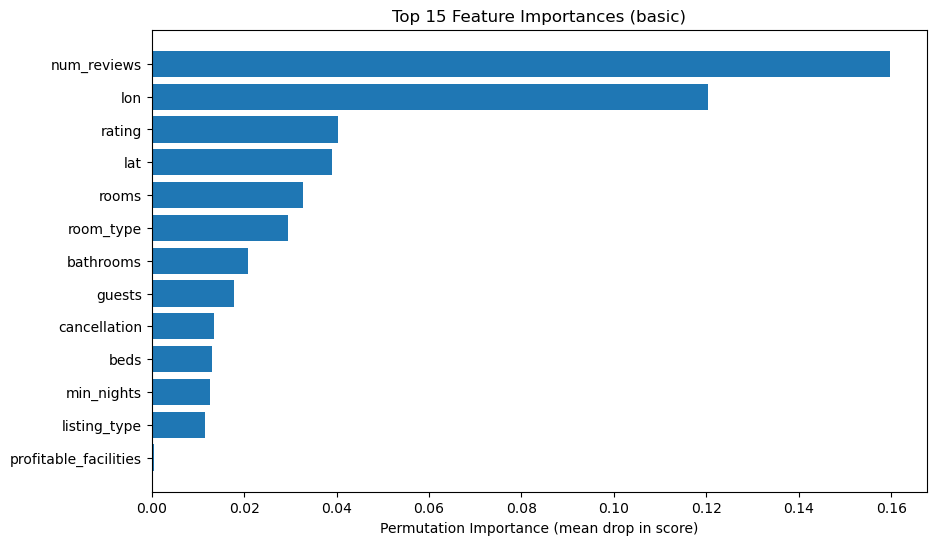

In [88]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## GradientBoostingRegressor

In [90]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:27:53,692 - INFO - Using preprocessor: simple_basic
2025-05-12 20:27:53,692 - INFO - Fitting model: GradientBoostingRegressor using simple_basic and search_type: none
2025-05-12 20:27:55,211 - INFO - GradientBoostingRegressor train MAE: 9534.57
2025-05-12 20:27:55,212 - INFO - GradientBoostingRegressor valid MAE: 9555.76
2025-05-12 20:27:55,213 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:27:55,213 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered and search_type: none
2025-05-12 20:27:57,280 - INFO - GradientBoostingRegressor train MAE: 9511.40
2025-05-12 20:27:57,281 - INFO - GradientBoostingRegressor valid MAE: 9564.62
2025-05-12 20:27:57,281 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:27:57,282 - INFO - Fitting model: GradientBoostingRegressor using simple_engineered_reduced and search_type: none
2025-05-12 20:27:58,797 - INFO - GradientBoostingRegressor train MAE: 9860.30
2025-05-12 20:27:58,797 - INFO 

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                             9509.53329
valid_mae                                            9493.322544
mae_diff                                               16.210746
feature_set                                                mixed
imputation                                                simple
features                                                   mixed
Name: 3, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                             9509.53329
valid_mae                                            9493.322544
mae_diff                                               16.210746
feature_set                                                mixed
imputation                                                simple
features                                                   mixed

### With RandomizedSearchCV

In [92]:
param_grid_gbr = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.03, 0.05, 0.1],
    'gradientboostingregressor__max_depth': [3, 5, 7],  # limit complexity
    'gradientboostingregressor__min_samples_split': [5, 10, 20],
    'gradientboostingregressor__min_samples_leaf': [2, 5, 10],  # prevent overfitting on noise
    'gradientboostingregressor__max_features': ['sqrt', 0.3, 0.5],  # try fractions too
    'gradientboostingregressor__subsample': [0.6, 0.8, 1.0],
    'gradientboostingregressor__loss': ['squared_error', 'huber'],  # 'huber' helps with outliers; add if needed
}


best_gbr = pipeline_iterator(
            model_type=GradientBoostingRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_gbr,
            n_iter=100,
            cv_folds=5
        )

2025-05-12 20:28:14,576 - INFO - Using preprocessor: simple_mixed
2025-05-12 20:28:14,578 - INFO - Fitting model: GradientBoostingRegressor using simple_mixed and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-12 20:30:28,549 - INFO - Best params: {'gradientboostingregressor__subsample': 0.6, 'gradientboostingregressor__n_estimators': 300, 'gradientboostingregressor__min_samples_split': 20, 'gradientboostingregressor__min_samples_leaf': 10, 'gradientboostingregressor__max_features': 0.3, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__learning_rate': 0.05}
2025-05-12 20:30:28,777 - INFO - GradientBoostingRegressor train MAE: 7082.90
2025-05-12 20:30:28,777 - INFO - GradientBoostingRegressor valid MAE: 8617.95


### Feature Importance

In [94]:
feature_set_used = best_gbr['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [95]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_gbr['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


                  feature  importance_mean  importance_std
1                     lon         0.178117        0.003745
0                     lat         0.081810        0.004204
9         rating_weighted         0.064971        0.002890
7             num_reviews         0.051823        0.003338
8                  rating         0.043605        0.003131
11              room_type         0.034832        0.001839
4               bathrooms         0.027188        0.001434
3                   rooms         0.026092        0.001522
6                  guests         0.018583        0.001849
2              min_nights         0.009258        0.001146
10         facility_count         0.006984        0.000988
13           listing_type         0.006977        0.001180
12           cancellation         0.004749        0.001258
5                    beds         0.002413        0.000505
14  profitable_facilities         0.000398        0.000097


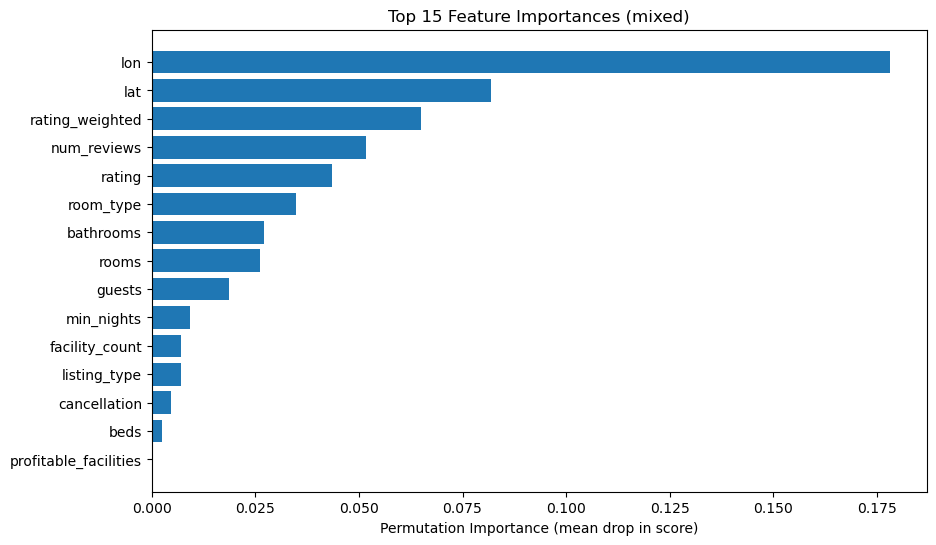

In [96]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## HistGradientBoostingRegresor

In [98]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:30:30,842 - INFO - Using preprocessor: simple_basic
2025-05-12 20:30:30,842 - INFO - Fitting model: HistGradientBoostingRegressor using simple_basic and search_type: none


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

### With RandomizedSearchCV

In [ ]:
param_grid_hgbr =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

best_hgbr = pipeline_iterator(
            model_type=HistGradientBoostingRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_hgbr,
            n_iter=100,
            cv_folds=5
        )

### Feature Importance

In [ ]:
feature_set_used = best_hgbr['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_hgbr['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## XGBoost

In [123]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=XGBRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

2025-05-12 20:31:16,876 - INFO - Using preprocessor: simple_basic
2025-05-12 20:31:16,877 - INFO - Fitting model: XGBRegressor using simple_basic and search_type: none
2025-05-12 20:31:17,190 - INFO - XGBRegressor train MAE: 6602.04
2025-05-12 20:31:17,191 - INFO - XGBRegressor valid MAE: 8963.92
2025-05-12 20:31:17,191 - INFO - Using preprocessor: simple_engineered
2025-05-12 20:31:17,192 - INFO - Fitting model: XGBRegressor using simple_engineered and search_type: none
2025-05-12 20:31:17,346 - INFO - XGBRegressor train MAE: 6427.90
2025-05-12 20:31:17,347 - INFO - XGBRegressor valid MAE: 10037.72
2025-05-12 20:31:17,347 - INFO - Using preprocessor: simple_engineered_reduced
2025-05-12 20:31:17,347 - INFO - Fitting model: XGBRegressor using simple_engineered_reduced and search_type: none
2025-05-12 20:31:17,502 - INFO - XGBRegressor train MAE: 6802.03
2025-05-12 20:31:17,502 - INFO - XGBRegressor valid MAE: 9680.33
2025-05-12 20:31:17,503 - INFO - Using preprocessor: simple_mixed
202

🔍 Best validation MAE:
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            6602.042969
valid_mae                                            8963.916992
mae_diff                                             2361.874023
feature_set                                                basic
imputation                                                simple
features                                                   basic
Name: 0, dtype: object

🧠 Best generalization (smallest MAE gap):
 pipeline       ((FunctionTransformer(func=<function make_prep...
train_mae                                            6602.042969
valid_mae                                            8963.916992
mae_diff                                             2361.874023
feature_set                                                basic
imputation                                                simple
features                                                   basic

### With RandomizedSearchCV

In [125]:
param_grid_xgb = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__learning_rate': [0.03, 0.05, 0.1],  # slightly slower but safer
    'xgbregressor__max_depth': [3, 5, 7],  # allow moderate complexity
    'xgbregressor__min_child_weight': [3, 5, 10],  # prevent overfitting from noisy low-count leaves
    'xgbregressor__gamma': [0, 0.2, 0.5],  # discourage unnecessary splits
    'xgbregressor__subsample': [0.7, 0.85, 1.0],  # adds randomness for generalization
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],  # feature-level randomness
    'xgbregressor__reg_alpha': [0, 0.1, 1],  # L1: helpful for sparse/irrelevant features
    'xgbregressor__reg_lambda': [1, 2, 5],   # L2: stabilizes model weights
}


best_xgb = pipeline_iterator(
            model_type=XGBRegressor,
            imputation='simple',
            feature_set='basic',
            search_type='random',
            param_grid=param_grid_xgb,
            n_iter=100,
            cv_folds=5
        )

2025-05-12 20:31:45,209 - INFO - Using preprocessor: simple_basic
2025-05-12 20:31:45,210 - INFO - Fitting model: XGBRegressor using simple_basic and search_type: random


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2025-05-12 20:32:44,842 - INFO - Best params: {'xgbregressor__subsample': 0.85, 'xgbregressor__reg_lambda': 5, 'xgbregressor__reg_alpha': 1, 'xgbregressor__n_estimators': 300, 'xgbregressor__min_child_weight': 3, 'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0.2, 'xgbregressor__colsample_bytree': 0.6}
2025-05-12 20:32:44,904 - INFO - XGBRegressor train MAE: 7267.48
2025-05-12 20:32:44,905 - INFO - XGBRegressor valid MAE: 8662.91


### Feature Importance

In [127]:
feature_set_used = best_xgb['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [129]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_xgb['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


                  feature  importance_mean  importance_std
1                     lon         0.185904        0.004260
7             num_reviews         0.185129        0.004022
0                     lat         0.088007        0.003224
8                  rating         0.063174        0.003973
9               room_type         0.035073        0.001907
3                   rooms         0.033839        0.001520
4               bathrooms         0.021491        0.001185
6                  guests         0.016352        0.001766
2              min_nights         0.010011        0.001070
10           cancellation         0.005960        0.000962
5                    beds         0.005216        0.000626
11           listing_type         0.005022        0.000886
12  profitable_facilities         0.000490        0.000209


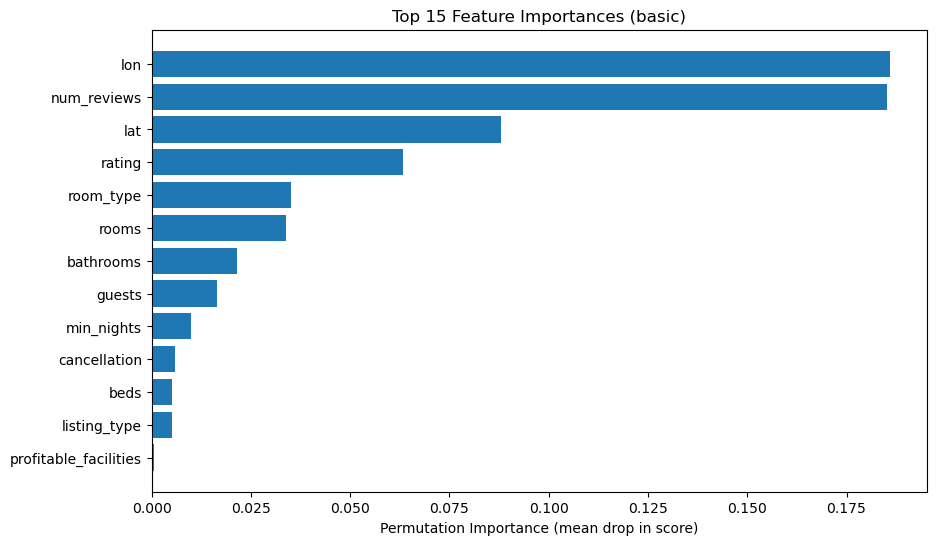

In [131]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


## LightGBM

In [ ]:
results = []
for i in imputation_types:
    for k in feature_sets:
        result = pipeline_iterator(
            model_type=LGBMRegressor,
            imputation=i,
            feature_set=k,
            search_type=None
        )
        result['imputation'] = i
        result['features'] = k
        results.append(result)

results_df = pd.DataFrame(results)

# Find best models:
best_valid = results_df.loc[results_df['valid_mae'].idxmin()]
best_generalization = results_df.loc[results_df['mae_diff'].idxmin()]

print("🔍 Best validation MAE:\n", best_valid)
print("\n🧠 Best generalization (smallest MAE gap):\n", best_generalization)

### With RandomizedSearchCV

In [ ]:
param_grid_lgbm = {
    'lgbmregressor__n_estimators': [200, 300, 500],                    # Enough rounds to converge
    'lgbmregressor__learning_rate': [0.03, 0.05, 0.1],                 # Slower, safer learning
    'lgbmregressor__max_depth': [4, 6, 8],                             # Lower max_depth reduces overfitting
    'lgbmregressor__num_leaves': [15, 31, 63],                         # Constrained complexity
    'lgbmregressor__min_child_samples': [10, 20, 50],                 # Control overfitting from noisy small leaves
    'lgbmregressor__subsample': [0.7, 0.9],                            # Row sampling for regularization
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],               # Column sampling
    'lgbmregressor__reg_alpha': [0.0, 0.1, 0.5],                       # L1 regularization
    'lgbmregressor__reg_lambda': [0.0, 0.1, 1.0],                      # L2 regularization
    'lgbmregressor__min_split_gain': [0.0, 0.01, 0.05]                 # Min gain to allow a split
}


best_lgbm = pipeline_iterator(
            model_type=LGBMRegressor,
            imputation='simple',
            feature_set='mixed',
            search_type='random',
            param_grid=param_grid_lgbm,
            n_iter=50,
            cv_folds=5
        )

### Feature Importance

In [ ]:
feature_set_used = best_lgbm['feature_set']
selected_features = get_selected_features(feature_set_used)
X_val_filtered = X_valid[selected_features]


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=best_lgbm['pipeline'],
    X=X_val_filtered,
    y=y_valid_log,  # or y_valid if you're not using log transform
    n_repeats=10,
    random_state=r_state,
    n_jobs=-1
)

importances_df = pd.DataFrame({
    'feature': X_val_filtered.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head(15))


In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'].head(15), importances_df['importance_mean'].head(15))
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title(f"Top 15 Feature Importances ({feature_set_used})")
plt.gca().invert_yaxis()
plt.show()


# Voting Regressor

In [133]:
# Combine fitted pipelines into a voting regressor
voting_model = VotingRegressor(estimators=[
    ('gbr', best_gbr['pipeline']),
    ('xgb', best_xgb['pipeline']),
    #('hgb', best_hgbr['pipeline']),
    #('lgbm', best_lgbm['pipeline'])
])


voting_model.fit(X_train, y_train_log)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


VotingRegressor(estimators=[('gbr',
                             RandomizedSearchCV(cv=5,
                                                estimator=Pipeline(steps=[('pipeline',
                                                                           Pipeline(steps=[('select',
                                                                                            FunctionTransformer(func=<function make_preprocessor.<locals>.select_columns at 0x00000188372AD940>)),
                                                                                           ('transform',
                                                                                            ColumnTransformer(transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer()),
                                                                                                                                             ('scaler',
                                                                                                                                              StandardScaler())]),
                                                                                                                             ['...
                                                                                             0.2,
                                                                                             0.5],
                                                                     'xgbregressor__learning_rate': [0.03,
                                                                                                     0.05,
                                                                                                     0.1],
                                                                     'xgbregressor__max_depth': [3,
                                                                                                 5,
                                                                                                 7],
                                                                     'xgbregressor__min_child_weight': [3,
                                                                                                        5,
                                                                                                        10],
                                                                     'xgbregressor__n_estimators': [100,
                                                                                                    200,
                                                                                                    300],
                                                                     'xgbregressor__reg_alpha': [0,
                                                                                                 0.1,
                                                                                                 1],
                                                                     'xgbregressor__reg_lambda': [1,
                                                                                                  2,
                                                                                                  5],
                                                                     'xgbregressor__subsample': [0.7,
                                                                                                 0.85,
                                                                                                 1.0]},
                                                random_state=123,
                                                scoring='neg_mean_absolute_error',
       

In [135]:

train_preds_log = voting_model.predict(X_train)
valid_preds_log = voting_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"VotingRegressor Train MAE: {train_mae:.2f}")
print(f"VotingRegressor Valid MAE: {valid_mae:.2f}")
print(f"VotingRegressor MAE diff: {valid_mae - train_mae:2f}")


VotingRegressor Train MAE: 7109.73
VotingRegressor Valid MAE: 8575.96
VotingRegressor MAE diff: 1466.227751


# Model Stacking

In [137]:
from sklearn.ensemble import StackingRegressor

# 1. Define the stacking regressor (base models already fitted pipelines)
stack = StackingRegressor(
    estimators=[
        #('lgbm', best_lgbm['pipeline']),
        ('xgb', best_xgb['pipeline']),
        #('hgbr', best_hgbr['pipeline']),
        ('gbr', best_gbr['pipeline']),
    ],
    final_estimator=Ridge(alpha=10),        # Meta-model to tune
    passthrough=False,              # Set True if you want to include original features too
    n_jobs=-1,
    cv=3
)

# 2. Define parameter grid to tune Ridge alpha
# param_grid = {
#     'final_estimator__alpha': [0.01, 0.1, 1, 10, 100]
# }

# # 3. Run grid search to tune final estimator
# search = GridSearchCV(
#     estimator=stack,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# 4. Fit the stacked model on training data
# search.fit(X_train, y_train_log)
stack.fit(X_train, y_train_log)

# 5. View best alpha and CV score
# print(f"Best alpha for Ridge meta-model: {search.best_params_['final_estimator__alpha']}")
# print(f"Best cross-validated MAE: {-search.best_score_:.2f}")

# # 6. Evaluate on validation set
# stacked_best = search.best_estimator_
# preds_log = stacked_best.predict(X_valid)
preds_log = stack.predict(X_valid)
preds = np.expm1(preds_log)
mae = mean_absolute_error(y_valid, preds)
print(f"Validation MAE for best stacked model: {mae:.2f}")



KeyboardInterrupt: 

In [ ]:
# Predict log-transformed outputs
train_preds_log = stack.predict(X_train)
valid_preds_log = stack.predict(X_valid)

# Inverse transform to original scale
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate MAE
train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

print(f"StackingRegressor Train MAE: {train_mae:.2f}")
print(f"StackingRegressor Valid MAE: {valid_mae:.2f}")

# OLD !!

## Gradient Boosted Regressor

## Baseline

In [ ]:

gbr_model = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

gbr_model.fit(X_train, y_train_log)


train_preds_log = gbr_model.predict(X_train)
valid_preds_log = gbr_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

## GBR RandomSearch

### Selected for voting

In [ ]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess1,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model1 = random_search.best_estimator_

train_preds_log = best_gbr_model1.predict(X_train)
valid_preds_log = best_gbr_model1.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## !Testing!

In [ ]:
# Define the pipeline with SimpleImputer
gbr_pipeline = make_pipeline(
    preprocess_guests,
    GradientBoostingRegressor(random_state=r_state)
)

# Define parameter grid for randomized search
param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5, 6],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    #'gradientboostingregressor__loss': ['absolute_error', 'squared_error', 'huber', 'quantile']
}


# Step 4: Run randomized search
random_search = RandomizedSearchCV(
    gbr_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

random_search.fit(X_train, y_train_log)  # fit on log-transformed target

# Step 5: Get best estimator and make predictions
best_gbr_model2 = random_search.best_estimator_

train_preds_log = best_gbr_model2.predict(X_train)
valid_preds_log = best_gbr_model2.predict(X_valid)

# Step 6: Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Step 7: Evaluate using original targets
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"RandomForest MAE on train set: {train_mae:.2f}")
logging.info(f"RandomForest MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## XGBoost

## Baseline

In [ ]:
from xgboost import XGBRegressor

xgb_model = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

xgb_model.fit(X_train, y_train_log)


train_preds_log = xgb_model.predict(X_train)
valid_preds_log = xgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"Gradient Boosting Train MAE: {train_mae:.2f}")
logging.info(f"Gradient Boosting Valid MAE: {valid_mae:.2f}")

## XGB RandomSearch

In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__min_child_weight': [1, 3, 5]
}

# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model = random_search.best_estimator_

train_preds_log = best_xgb_model.predict(X_train)
valid_preds_log = best_xgb_model.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## !Testing!

### Selected for voting

In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess1,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model1 = random_search.best_estimator_

train_preds_log = best_xgb_model1.predict(X_train)
valid_preds_log = best_xgb_model1.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Use raw X_train (NOT transformed — the pipeline handles that)
PartialDependenceDisplay.from_estimator(
    best_xgb_model,                # your full fitted pipeline
    X_train,                       # raw features with column names
    features=['rooms', 'min_nights', 'rating', 'num_reviews', 'lat', 'lon', 'bathrooms', 'beds'],  # any continuous feature names
    kind='average',
    grid_resolution=30
)
plt.show()




In [ ]:
# Turn search results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Convert the score to positive MAE
results['mae'] = -results['mean_test_score']

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(results['param_xgbregressor__max_depth'], results['mae'])
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Effect of max_depth on MAE')
plt.grid(True)
plt.show()



In [ ]:
# Define the pipeline using your existing preprocess1
xgb_pipeline = make_pipeline(
    preprocess_guests,
    XGBRegressor(random_state=r_state, objective='reg:squarederror', verbosity=0)
)

# Define parameter grid for randomized search
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300, 400],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 4, 5, 6, 8],
    'xgbregressor__min_child_weight': [1, 3, 5, 7],
    'xgbregressor__gamma': [0, 0.1, 0.3, 0.5],  # minimum loss reduction for a split
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1.0],  # L1 regularization
    'xgbregressor__reg_lambda': [1.0, 1.5, 2.0],     # L2 regularization
    #'xgbregressor__booster': ['gbtree', 'dart'],     # 'gblinear' is not ideal for tabular
    #'xgbregressor__max_delta_step': [0, 1, 5]        # for better convergence in imbalanced cases
}


# Run randomized search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=r_state,
    n_jobs=-1,
    verbose=4
)

logging.info("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train_log)  # Fit on log-transformed target

# Get best estimator and make predictions
best_xgb_model2 = random_search.best_estimator_

train_preds_log = best_xgb_model2.predict(X_train)
valid_preds_log = best_xgb_model2.predict(X_valid)

# Inverse transform predictions
train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)

# Evaluate
train_mae = mean_absolute_error(raw_train['revenue'], train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"XGBoost MAE on train set: {train_mae:.2f}")
logging.info(f"XGBoost MAE on validation set: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")

## HistGradientRegressor

## Baseline

In [ ]:

hgb_model = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

logging.info("Fitting HistGradientBoostingRegressor...")
hgb_model.fit(X_train, y_train_log)


train_preds_log = hgb_model.predict(X_train)
valid_preds_log = hgb_model.predict(X_valid)

train_preds = np.expm1(train_preds_log)
valid_preds = np.expm1(valid_preds_log)


train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")

## HistGradient RandomSearch

In [ ]:


# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess1,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid = {
    'histgradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300],
    'histgradientboostingregressor__max_depth': [None, 5, 10],
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 1.0]
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model.predict(X_train))
valid_preds = np.expm1(best_hgb_model.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")


## !Testing!

### Selected for voting 

In [ ]:
# Define the pipeline (assuming you already have `preprocess1`)
hgb_pipeline = make_pipeline(
    preprocess_guests,
    HistGradientBoostingRegressor(random_state=r_state)
)

# Define the hyperparameter grid
param_grid =  {
    'histgradientboostingregressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'histgradientboostingregressor__max_iter': [100, 200, 300, 500],  # like n_estimators
    'histgradientboostingregressor__max_depth': [None, 5, 10, 20],     # controls tree depth
    'histgradientboostingregressor__min_samples_leaf': [10, 20, 50, 100],
    'histgradientboostingregressor__l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'histgradientboostingregressor__max_leaf_nodes': [15, 31, 63],     # cap on tree complexity
    'histgradientboostingregressor__early_stopping': [False],          # we control stopping manually
    'histgradientboostingregressor__scoring': [None],                  # uses loss, not validation metric
    'histgradientboostingregressor__monotonic_cst': [None],            # can later test constraints
    'histgradientboostingregressor__categorical_features': [None], 
}

# Setup randomized search
random_search = RandomizedSearchCV(
    hgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=r_state,
    verbose=4
)

# Fit the model on the log-transformed target
random_search.fit(X_train, y_train_log)

# Retrieve best model
best_hgb_model1 = random_search.best_estimator_

# Predict and evaluate
train_preds = np.expm1(best_hgb_model1.predict(X_train))
valid_preds = np.expm1(best_hgb_model1.predict(X_valid))

train_mae = mean_absolute_error(y_train, train_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)

logging.info(f"HistGradientBoosting Train MAE: {train_mae:.2f}")
logging.info(f"HistGradientBoosting Valid MAE: {valid_mae:.2f}")
logging.info(f"Best params: {random_search.best_params_}")
